# Grid Search and Cross-Validation

_Author: Michael Frantz (LA)_

---


In [1]:
!pip --quiet install mglearn

In [2]:
import mglearn
from sklearn.linear_model import Ridge, Lasso, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Review: Bias and Variance

---
![](http://tomrobertshaw.net/img/2015/12/overfitting.jpg)

### Discussion:
Answer these three questions about the above models given the data. 

1. Out of these three, which one would you pick as a low bias model? Why?
1. Out of these three, which would you pick as a low variance model? Why?
1. Out of these three, which one would you chose? Why?
1. What are some current methods we have learned for **reducing variance**?

In [3]:
# A: 

#### Answer:

1. The model on the right is the lowest bias. It learned the data the best and would have a training accuracy, precision, and recall of 1. 
2. The model in the middle has the lowest variance. It doesn't get all the training examples correct, but it will likely generalize to new data better than the model on the left or right. 
3. The middle model, for the reason above. 
4. Regularization ($\alpha$ from Ridge and Lasso, `C` from LogisticRegression (this is $\frac{1}{\alpha}$).

## Tuning Hyperparameters
---

We've now covered a number of regressors and classifiers, including:
* `KNeighborsClassifier`
* `LogisticRegression`
* `Ridge`
* `Lasso`

Each of these models have what are called **hyperparameters**, which affect how the model learns the data. Think of them like dials, and by changing them, we can optimize a model's performance on new data (a.k.a. **reduce variance**)!

* What is the hyperparameter for `KNeighborsClassifier`?
* What are the hyperparameters for `Ridge`?

Up until now, we've used:
> **"Training set":** the subset of the data that we fit our model on.

> **"Testing set":** the subset of the data that we evaluate the quality of our predictions on.

We've tuned our hyperparameters by hand so our model performs well on a test set. But now, instead of overfitting to our training set, we may be overfitting to our test set! Ultimately, we want to find optimal values for our hyperparameters **without touching our test data**. **BUT HOW?!?!?!**

The trick is to add *another* set of splits. We're going to use cross-validation **within the training set** to fit our models and tune our hyperparamets, then **evaluate** on the test set. Let's spend a minute on the figure below. Notice:

* When we originally fit our models, we use cross-validation to identify bias and variance, and adjust our hyperamaters to improve our model.
* In the top panel, we don't do anything with our test set.
* In the bottom panel, once we've tuned our hyperparameters, we can **re-fit** on all our training data to predict our **test** data and perform a model evaluation.

**NOTE:** We have not covered SVC as a model yet; for now, think of it as a general classifier. Also, this figure is called `plot_improper_processing`; you will soon be getting the last piece of the puzzle. I'll be super amped if you can tell me what this format is missing!

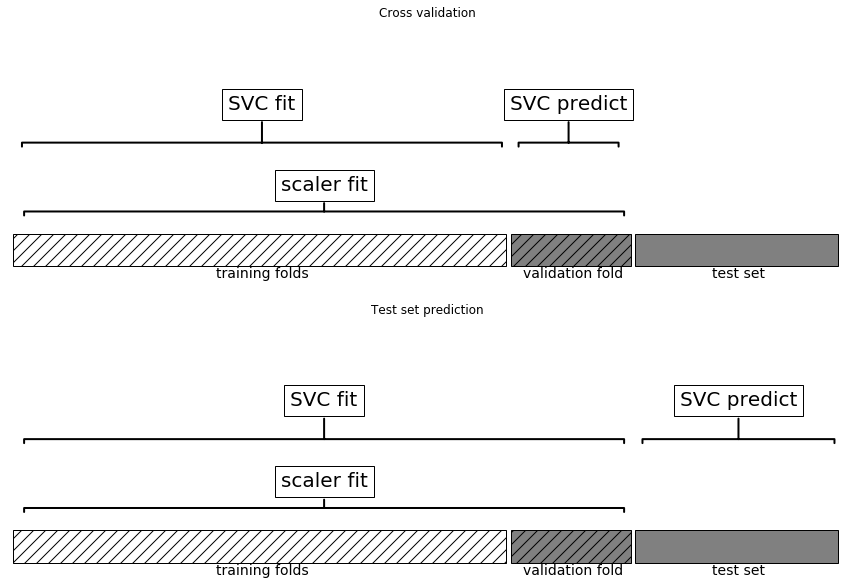

In [4]:
mglearn.plot_improper_preprocessing.plot_improper_processing()

## Introducing (drum roll please...) `GridSearchCV`

What if there was a way we could reduce variance by tuning hyperparameters without even touching our test dataset? To do this, we use the `sklearn` class `GridSearchCV`. Let's dive in:

### Setting up `GridSearchCV`

##### 1. Estimator

First, pick your estimator. This can be any `sklearn` model. Today, we'll use `KNeighborsClassifier`. This is passed to the `estimator` argument.

##### 2. Parameter Grid:

The second thing you should do when setting up a grid search is create a parameter grid. This allows you to input values for all the hyperparameters you'd like to tune! Here's an example of a parameter grid for `KNeighborsClassifier`. The only hyperparameter we can tune here is `n_neighbors`, which makes this task pretty simple. Let's try every value between 1 and 10.

```
knc_params = {
        'n_neighbors':range(1,11)
    }
```
Your param grid is then passed to your grid search object through the argument `param_grid`.

##### 3.  Cross-Valisation:

Cross-validation is defined by the `cv=` argument. `cv` can be an integer, `ShuffleSplit`, or `StratifiedShuffleSplit` object.
* `cv=5` will perform 5-fold cross-validation
* `ShuffleSplit` will shuffle your samples for random validation sets. Default `cv` argument for this object is 10. If you want 5-fold cross-validation using all the data with `ShuffleSplit`, use `cv=ShuffleSplit(cv=10, test_size = .2)`.
* `StratifiedShuffleSplit` is similar to `ShuffleSplit`, but can only be used for classificaion. This ensures that the class proportion in your target are preserved in each validation split.


##### Note:

`GridSearchCV` also takes an argument for `n_jobs`, with a default of 1. Many `sklearn` objects take this argument. If you set `n_jobs=-1`, `sklearn` will parallelize this process accross all the cores in your machine. This can really help speed up model training!


## Ok, now what does `GridSearchCV` do with that info?

When we use `.fit()` on your instantiated `GridSearchCV` object, it does a few things:
1. For each combination of hyperparameters, it performs cross-validation and gets a mean train score and mean test score. **Question:** If we do 5-fold cross validaion on a `param_grid` for `Ridge` where `param_grid = {'c':range(1,6)}`, how many individual models are fit?
2. For the combination of parameters with the **best mean test score**, `GridSearchCV` re-fits **all the training data** using those best parameters. 

**Question:** If your `GridSearchCV` is taking *REEEEEEEAAALLY* long to run `.fit()`, what are some options you have to reduce the time?

Let's spend a minute and review the graphic below to review what `GridSearchCV` is doing.

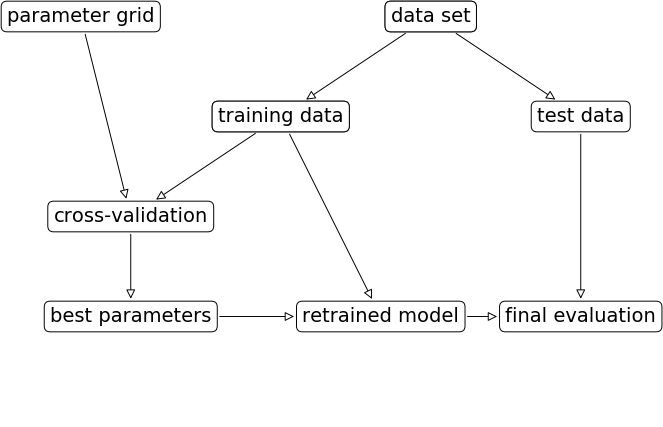

In [5]:
mglearn.plot_grid_search.plot_grid_search_overview()

## Ok, enough talk! Let's code it up. 

**NOTE:** Because we want to spend time with GridSearch, I've left the data cleaning in for you. However, if you have time, it would be great to review the steps taken to clean this data and try replicating them on your own. I've explained what we're doing step-by-step:

In [6]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit, StratifiedShuffleSplit, train_test_split

Load the data:

In [7]:
data = pd.read_csv('datasets/basketball_data.csv')
# Set the index to the `GameID`
data.set_index('GameId', inplace=True)
data.head()

,Season,GameDate,GameTime,HostName,GuestName,total_score,total_line,game_line,Host_HostRank,Host_GameRank,...,gPTS_avg10,gTS%_avg10,g3PAR_avg10,gFTr_avg10,gDRB%_avg10,gTRB%_avg10,gAST%_avg10,gSTL%_avg10,gBLK%_avg10,gDRtg_avg10
GameId,,,,,,,,,,,,,,,,,,,,,
201212090LAL,2013,2012-12-09,6:30 pm,Los Angeles Lakers,Utah Jazz,227.0,207.5,7.5,13,21,...,99.0,0.5206,0.2230,0.2981,69.22,50.05,61.57,8.63,10.31,110.87
201212100PHI,2013,2012-12-10,7:00 pm,Philadelphia 76ers,Detroit Pistons,201.0,186.5,5.5,13,21,...,90.3,0.5077,0.2144,0.3095,71.46,49.48,59.83,6.48,9.46,107.91
201212100HOU,2013,2012-12-10,7:00 pm,Houston Rockets,San Antonio Spurs,240.0,212.0,-7.0,12,20,...,108.0,0.5915,0.2743,0.2518,74.26,50.99,61.82,8.30,6.85,101.41
201212110BRK,2013,2012-12-11,7:00 pm,Brooklyn Nets,New York Knicks,197.0,195.5,-3.5,12,20,...,100.3,0.5473,0.3595,0.2544,74.23,47.88,52.07,9.31,7.64,109.24
201212110DET,2013,2012-12-11,7:30 pm,Detroit Pistons,Denver Nuggets,195.0,203.5,-4.5,11,24,...,101.1,0.5605,0.2173,0.3177,68.45,50.40,56.33,7.67,7.83,114.86


Extract the month and day of week from the data using `pandas datetime` functionality:

In [8]:
# Change the GameDate colum to datetime type
data.GameDate = pd.to_datetime(data['GameDate'])
# Extract the day of week and month of the game into their own columns
data['GameMonth'] = data['GameDate'].apply(lambda x: x.month)
data['GameDayofWeek'] = data['GameDate'].apply(lambda x: x.dayofweek)

View the non-numeric columns in this dataset using `df.select_dtypes`

In [9]:
data.select_dtypes(include=['object']).head()

,GameTime,HostName,GuestName,winner,loser
GameId,,,,,
201212090LAL,6:30 pm,Los Angeles Lakers,Utah Jazz,Utah Jazz,Los Angeles Lakers
201212100PHI,7:00 pm,Philadelphia 76ers,Detroit Pistons,Philadelphia 76ers,Detroit Pistons
201212100HOU,7:00 pm,Houston Rockets,San Antonio Spurs,San Antonio Spurs,Houston Rockets
201212110BRK,7:00 pm,Brooklyn Nets,New York Knicks,New York Knicks,Brooklyn Nets
201212110DET,7:30 pm,Detroit Pistons,Denver Nuggets,Denver Nuggets,Detroit Pistons


Make our target whether the home team wins in a new columna called `host_wins`

In [10]:
data['host_wins'] = data['HostName'] == data['winner']

Drop the winner and loser columns from the dataset.

In [11]:
data.drop(['winner','loser','GameDate'],axis=1, inplace=True)

We still have a few `object` columns in this dataset. Let's use `pd.get_dummies` to change these into numeric columns. 

In [12]:
data_dummies = pd.get_dummies(data)
data_dummies.head()

,Season,total_score,total_line,game_line,Host_HostRank,Host_GameRank,Guest_GuestRank,Guest_GameRank,host_win_count,host_lose_count,...,GuestName_Oklahoma City Thunder,GuestName_Orlando Magic,GuestName_Philadelphia 76ers,GuestName_Phoenix Suns,GuestName_Portland Trail Blazers,GuestName_Sacramento Kings,GuestName_San Antonio Spurs,GuestName_Toronto Raptors,GuestName_Utah Jazz,GuestName_Washington Wizards
GameId,,,,,,,,,,,,,,,,,,,,,
201212090LAL,2013,227.0,207.5,7.5,13,21,13,22,9,11,...,0,0,0,0,0,0,0,0,1,0
201212100PHI,2013,201.0,186.5,5.5,13,21,13,23,11,9,...,0,0,0,0,0,0,0,0,0,0
201212100HOU,2013,240.0,212.0,-7.0,12,20,13,22,9,10,...,0,0,0,0,0,0,1,0,0,0
201212110BRK,2013,197.0,195.5,-3.5,12,20,13,21,11,8,...,0,0,0,0,0,0,0,0,0,0
201212110DET,2013,195.0,203.5,-4.5,11,24,16,22,7,16,...,0,0,0,0,0,0,0,0,0,0


##### Question:
What do you think `pd.get_dummies` does?

Finally, let's split the data into our `features` and `target`. 

In [13]:
target = data_dummies['host_wins']
features = data_dummies.drop('host_wins',axis=1)

Now's where you take over! 

### Exercise: `GridSearchCV` Workflow

Perform a `train_test_split` on the data: 
* Your split data `X_train, X_test, y_train, y_test`. 
* Use a `test_size` of .25
* Use a `random_state` of 42 so we all have the same results

In [14]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = .25, random_state = 42)

Import `KNeighborsClassifier` and `LogisticRegression`

In [15]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

Instantiate a `StandardScaler` object. `.fit` the scaler object on your training data (`X_train`), and then `.transform` both your training and test features so they are all scaled.

Coming out of this, you should have two new `np.ndarray`s: `X_train_scaled` and `X_test_scaled`. 

**Question:** Why do we fit the scaler on only the training data? Why do we transform both the train and test data?

In [16]:
from sklearn.preprocessing import StandardScaler

In [17]:
scaler = StandardScaler()
scaler.fit(X_train)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [18]:
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Ok, let's set up a `param_grid` for KNeighborsClassifier. Let's try neighbors from 5 to 50 with intervals of 5. Ex: `[5,10,15,...,45,50]`

In [19]:
knc_params = {
    'n_neighbors': range(5,51,5)
}

Almost there! Lets' instantiate our `GridSearchCV` object where...
* our `estimator` is `KNeighborsClassifier`
* our `param_grid` is our `knc_params`
* our `cv=5` (5-fold cross-validation)

In [20]:
knc_gs = GridSearchCV(KNeighborsClassifier(), param_grid= knc_params, cv=5)

Use `.fit` once to fit ALL OUR MODELS!

**Question:** Which of the below dataset pairs do we use to fit on? Why?
1. `.fit(X_train, y_test)`
1. `.fit(X_test, y_train)`
1. `.fit(X_train, y_train)`
1. `.fit(X_test, y_test)`
1. `.fit(X_train, y_train)`
1. `.fit(X_train_scaled, y_train)`
1. `.fit(X_test_scaled, y_test)`
1. `.fit(X_train_scaled, y_train_scaled)`

In [21]:
knc_gs.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': range(5, 51, 5)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

That took way longer than we're used to... 
**Question:** Why?

## Let's explore the **methods** and **attributes** available to our fit `GridSearchCV` object.

### `.cv_results_`

This method summarizes all the results of all our cross-validated models. Let's put it and a DataFrame and see what we get!

Notice the column names. Since we did 5-fold cross-validation, every time we see a mean, we're evaluating the mean of 5 individual fits on different folds of our cross-validation.

In [22]:
cv_results = pd.DataFrame(knc_gs.cv_results_)
cv_results.head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.032509,0.472356,0.611465,0.753274,5,{'n_neighbors': 5},10,0.613074,0.766814,0.641343,...,0.601770,0.739054,0.582301,0.753649,0.618794,0.753316,0.019788,0.076639,0.019465,0.008784
1,0.042622,0.549039,0.617834,0.709130,10,{'n_neighbors': 10},9,0.616608,0.718584,0.648410,...,0.598230,0.710305,0.610619,0.701460,0.615248,0.709991,0.045840,0.323663,0.016617,0.005743
2,0.019662,0.391880,0.640835,0.703290,15,{'n_neighbors': 15},8,0.621908,0.706195,0.671378,...,0.628319,0.712517,0.644248,0.695268,0.638298,0.706012,0.001144,0.006145,0.017132,0.006511
3,0.020016,0.378009,0.649328,0.697010,20,{'n_neighbors': 20},7,0.625442,0.702212,0.683746,...,0.631858,0.699248,0.642478,0.691287,0.663121,0.697613,0.000796,0.003862,0.021445,0.003757
4,0.021532,0.383629,0.657820,0.698690,25,{'n_neighbors': 25},6,0.632509,0.702212,0.674912,...,0.661947,0.704998,0.660177,0.693941,0.659574,0.701149,0.000853,0.006444,0.013855,0.005247


Below, let's sort our `cv_results` dataframe by `mean_test_score` using `.sort_values`. 

**Question:** How many neighbors give us our best score?

In [23]:
cv_results.sort_values('mean_test_score', ascending=False).head()

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_neighbors,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,...,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
9,0.023496,0.433538,0.668436,0.690817,50,{'n_neighbors': 50},1,0.641343,0.688053,0.706714,...,0.667257,0.700575,0.660177,0.685980,0.666667,0.691866,0.002307,0.039468,0.021331,0.005247
8,0.020923,0.390991,0.665251,0.687721,45,{'n_neighbors': 45},2,0.639576,0.693363,0.701413,...,0.653097,0.698364,0.663717,0.677134,0.668440,0.688329,0.000702,0.008103,0.020639,0.007711
7,0.020618,0.391155,0.663482,0.691259,40,{'n_neighbors': 40},3,0.634276,0.691593,0.696113,...,0.656637,0.700133,0.663717,0.688633,0.666667,0.694960,0.000532,0.007516,0.019887,0.006407
5,0.021620,0.388672,0.661005,0.699575,30,{'n_neighbors': 30},4,0.636042,0.700885,0.690813,...,0.653097,0.705440,0.661947,0.693941,0.663121,0.703802,0.001028,0.005896,0.017786,0.004879
6,0.020513,0.388758,0.658528,0.691259,35,{'n_neighbors': 35},5,0.628975,0.696018,0.690813,...,0.656637,0.693498,0.660177,0.682884,0.656028,0.697171,0.000421,0.006602,0.019651,0.005537


### `.best_score_`

Let's say we don't want to look at the `cv_results_`. This attribute gives the **best mean test score** from our `cv_results_`. 

In [24]:
knc_gs.best_score_

0.66843595187544236

### `.best_params_`

This attribute returns the parameters for the model that got the best mean test score.

In [25]:
knc_gs.best_params_

{'n_neighbors': 50}

### `.best_estimator_`

The `best_estimator_` is an **actual model**. When we call `.predict()` on our `GridSearchCV` object, this is the model that it's using in the background. Notice that the `best_estimator_` has the hyperparameters from `best_params_`. Let's check it out!

In [26]:
knc_gs.best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=50, p=2,
           weights='uniform')

### `.predict()`

This works just like the `predict` method on any other `sklearn` estimator. Let's try it out creating a `y_test_pred` array!

**Note:** If your `estimator` is a classifier, you also have `.predict_proba()` available to you.

**Question:** Which dataset goes into the `.predict()` method if we want our test predictions?

1. `X_train`
1. `X_train_scaled`
1. `X_test`
1. `X_test_scaled`
1. `y_train`
1. `y_train_scaled`
1. `y_test`
1. `y_test_scaled`

In [27]:
y_test_pred = knc_gs.predict(X_test_scaled)

### `.score()` 

This **inherits** the `.score()` functoin from our `estimator`. So, if we're doing classification, the default will be accuracy, and for regressors, the default will be $r^2$.

What is the **train score**? What is the **test score**? What's your interpretation about our model's capacity to generalize to unseen data? What does that mean in terms of bias and variance?

In [28]:
knc_gs.score(X_train_scaled, y_train)

0.69037508846426043

In [29]:
knc_gs.score(X_test_scaled, y_test)

0.67622080679405516

In our `train` and `test` y's, what percent of the time does the home team win? i.e. what is the accuracy if we guessed the home team won every time? (`y_pred` is all ones)

In [30]:
y_train.mean()

0.58881811748053792

In [31]:
y_test.mean()

0.61040339702760082

Does our model out-perform chance?

Yes! While it's not perfect, it's a lot better than chance. 

**Let's go back up to where we define our grid search object and use `StratifiedShuffleSplit` as an example.**

### (if time permits) Exercise:

Use `GridSearchCV` with `LogisticRegression` to see if this model out-performs your nearest neighbors model.

* What hyperparameters can we tune for `LogisticRegression`? Let's tune `C` and `penalty`. Let's use a `np.logspace(-3,3,7)` for our `C` hyperparameter, and try both a `l1` and `l2` penalty. 
* Try using `ShuffleSplit` or `StratifiedShuffleSplit` with 5-fold cross-validation.

What are the `best_params_`? The `best_score_`?

In [32]:
lr_params = {
    'C':np.logspace(-3,3,7),
    'penalty':['l2','l1']
}

In [33]:
lrgs = GridSearchCV(LogisticRegression(n_jobs=-1),
                    param_grid=lr_params,
                    cv=StratifiedShuffleSplit(n_splits=5, test_size=.2, random_state=42),
                    n_jobs=-1)

In [34]:
lrgs.fit(X_train_scaled, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=42, test_size=0.2,
            train_size=None),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'penalty': ['l2', 'l1'], 'C': array([  1.00000e-03,   1.00000e-02,   1.00000e-01,   1.00000e+00,
         1.00000e+01,   1.00000e+02,   1.00000e+03])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [35]:
lrgs.best_score_

0.68975265017667842

In [36]:
lrgs.best_params_

{'C': 0.10000000000000001, 'penalty': 'l1'}

In [37]:
lrgs.score(X_train_scaled, y_train)

0.70771408351026188

In [38]:
lrgs.score(X_test_scaled, y_test)

0.69426751592356684

Let's plot out our mean test score over different values of `C` from our `.cv_results_`.

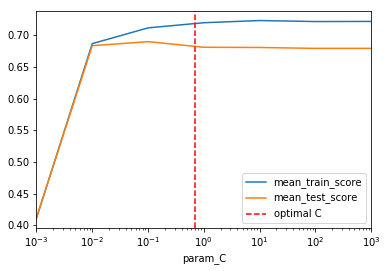

In [39]:
lrgs_results_df = pd.DataFrame(lrgs.cv_results_)

(lrgs_results_df[lrgs_results_df['param_penalty'] == 'l1']
 [['mean_train_score','mean_test_score','param_C']]
 .plot(x='param_C'))

plt.axvline(lrgs_results_df[lrgs_results_df['param_penalty'] == 'l1']['mean_test_score'].max(), c='r', ls='--', label = 'optimal C')

plt.legend()
plt.xscale('log')

## In Conclusion...

`GridSearchCV` performs two primary functions:

* Cross-validation, to **identify bias and variance** during training
* Grid Search, to **reduce bias and variance** by testing many combinations of model hyperparameters at once **without looking at our test data!**